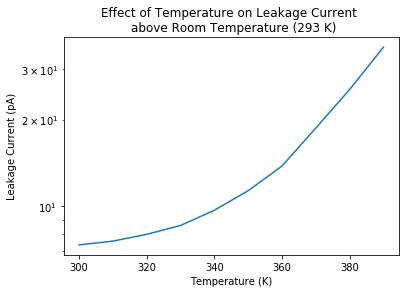

In [102]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy import random
import time


def temp(T):
    numTSteps = 2000 # Number of time steps
    N = 100 # Number of positions / electric field sheets

    initialCC = 2000 # Inital Number of charge carriers for each holes, Na, Nd, and electrons
    dt = 5.88 * 10 ** (-14) # Time step
    dx = 2.0 * 10 ** (-8) # Position step
    A = 1.0 * 10 ** (-11) # Area of PN-junction interface
    N_a = initialCC
    N_d = initialCC

    holes_init = initialCC
    elecs_init = initialCC


    eps_s = 12 * 8.85 * 10 ** (-12)
    eC = 1.6 * 10 ** (-19)

    k = 1.38 * 10 ** (-23)
    #T = 100


    E_0 = eC / (eps_s * A)
    thermal_voltage = k * T / eC
    E_g0 = 1.17
    E_g = E_g0 - 4.73 * 10 ** (-4) * T ** 2 / (T + 636)
    min_carriers = 2 * (T / 300) ** 1.5 * math.exp(E_g * eC / (2.0 * k) * (1 / 300.0 - 1.0 / T)) # minority carrier concentration

    mobility_p = 0.04 * (T / 300) ** (-1.5)# mu value for hole
    mobility_n = 0.13 * (T / 300) ** (-1.5)# mu value for electron

    c1_p = mobility_p * E_0 * dt / (2 * dx)
    c2_p = (thermal_voltage * mobility_p) * dt / (dx ** 2) 

    c1_n = mobility_n * E_0 * dt / (2 * dx)
    c2_n = (thermal_voltage * mobility_n) * dt / (dx ** 2)

    Na = np.concatenate(((-1) * np.ones(N / 2) * N_a, np.zeros(N / 2)))
    Nd = np.concatenate((np.zeros(N / 2), np.ones(N / 2) * N_d))

    holes = np.concatenate((np.ones(N / 2) * holes_init, np.ones(N / 2) * min_carriers))
    elecs = np.concatenate((np.ones(N / 2) * min_carriers, np.ones(N / 2) * elecs_init))

    E = np.zeros(N)
    r_holes = np.zeros(N)
    r_elecs = np.zeros(N)
    l_holes = np.zeros(N)
    l_elecs = np.zeros(N)

    holes_tot = np.zeros(N)
    elecs_tot = np.zeros(N)

    E_tot = np.zeros(N)

    loop = 200

    # 2. Begin Simulation 

    for n in range(numTSteps): # Over Time
        temporaryH = np.zeros(N)
        temporaryE = np.zeros(N)

        for i in range(N): # Over Position
            #Determine Electric Field at Position i (External Voltage will be accounted for by adding another term)
            if i == 0:
                E[i] = (-1) * np.sum(holes[1:N] - elecs[1:N] + Na[1:N] + Nd[1:N]) / 2
            elif i == (N - 1): 
                E[i] = np.sum(holes[0:N-1] - elecs[0:N-1] + Na[0:N-1] + Nd[0:N-1]) / 2
            else:
                pos = range(0, i)
                neg = range(i + 1, N)

                pos_field = np.sum(holes[pos] - elecs[pos] + Na[pos] + Nd[pos])
                neg_field = np.sum(holes[neg] - elecs[neg] + Na[neg] + Nd[neg])

                E[i] = (pos_field - neg_field) / 2; 

            # Calculate probabilities of carrier motion 
            r_holes[i] = E[i] * c1_p + c2_p
            l_holes[i] = (-1) * E[i] * c1_p + c2_p
            r_elecs[i] = (-1) * E[i] * c1_n + c2_n
            l_elecs[i] = E[i] * c1_n + c2_n

            # Move the holes 
            numH = holes[i]
            numRight = 0
            numLeft = 0
            numStay = 0



            if r_holes[i] < 0:
                numRight = 0 
            elif r_holes[i] > 1: 
                numRight = numH
            else:
                numRight = int(r_holes[i] * numH)

            if l_holes[i] < 0:
                numLeft = 0 
            elif l_holes[i] > 1: 
                numLeft = numH
            else:
                numLeft = int(l_holes[i] * numH)

            numStay = numH - numRight - numLeft


            if i == 0:
                temporaryH[1] += numRight
                temporaryH[0] += numStay + numLeft

            elif i == (N - 1):
                temporaryH[N-1] += numStay + numRight
                temporaryH[N-2] += numLeft

            else:
                temporaryH[i] += numStay
                temporaryH[i - 1] += numLeft
                temporaryH[i + 1] += numRight

            # Move the electrons
            numE = elecs[i]
            numRight = 0
            numLeft = 0
            numStay = 0

            if r_elecs[i] < 0:
                numRight = 0 
            elif r_elecs[i] > 1: 
                numRight = numE
            else:
                numRight = int(r_elecs[i] * numE)

            if l_elecs[i] < 0:
                numLeft = 0 
            elif l_elecs[i] > 1: 
                numLeft = numE
            else:
                numLeft = int(l_elecs[i] * numE)


            numStay = numE - numRight - numLeft
            if i == 0:
                temporaryE[1] += numRight
                temporaryE[0] += numStay + numLeft

            elif i == (N - 1):
                temporaryE[N-1] += numStay + numRight
                temporaryE[N-2] += numLeft

            else:
                temporaryE[i] += numStay
                temporaryE[i - 1] += numLeft
                temporaryE[i + 1] += numRight

        # Update carrier distribution
        holes = temporaryH
        elecs = temporaryE

        # EHP Generation by EM Stimulation
#         depletion_right = 55
#         depletion_left = 45

#         EHP_gen_num = 0

#         for i in range(EHP_gen_num):
#             x = random.randint(depletion_left, depletion_right)
#             holes[x] += 1
#             elecs[x] += 1

        if n > (numTSteps - loop): # Averaging distribution over time
            holes_tot += holes
            elecs_tot += elecs
            E_tot += E

    holes_tot = holes_tot / loop
    elecs_tot = elecs_tot / loop
    E_tot = E_tot / loop
    tot = holes_tot - elecs_tot + Nd + Na

    sum = 0
    voltArray = []

    for i in range(N):
        sum += E_tot[i] * dx * E_0
        voltArray.append((-1) * sum)

    voltage = (voltArray[N-1] - voltArray[0])
    
    dif = math.sqrt((2 * eps_s * voltage) / eC * (5 * 10 ** (-23))) / dx

    Q_n = 0
    depletion_left = int(49 - dif)
    for i in range(depletion_left):
        Q_n += elecs[i]

    Q_p = 0 
    depletion_right = int(49 + dif)
    for i in range(depletion_right, N): 
        Q_p += holes[i]

    tau_p = 10 ** (-4) # Will adjust value to experimentally determined values
    tau_n = 10 ** (-4)

    I_tot = (Q_p / tau_p + Q_n / tau_n) * eC
    
    return(I_tot)

tempValues = np.arange(300.0, 400.0, 10)
resultValues = []

for tempa in tempValues:
    result = temp(tempa)
    resultValues.append(result)

plt.plot(tempValues, [i * 10 ** 12 for i in resultValues])
plt.title("Effect of Temperature on Leakage Current \n above Room Temperature (293 K)")
plt.xlabel("Temperature (K)")
plt.ylabel("Leakage Current (pA)")
plt.yscale("log")
plt.show()

46
300.0
7.2928e-12
46
310.0
7.515503700861207e-12
46
320.0
7.931006906776328e-12
46
330.0
8.52152895612148e-12
46
340.0
9.622699737041055e-12
46
350.0
1.1257580675199268e-11
45
360.0
1.3750879291696614e-11
45
370.0
1.864998745922224e-11
45
380.0
2.5375084087113582e-11
45
390.0
3.558968748726322e-11


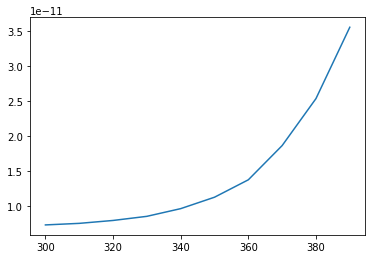

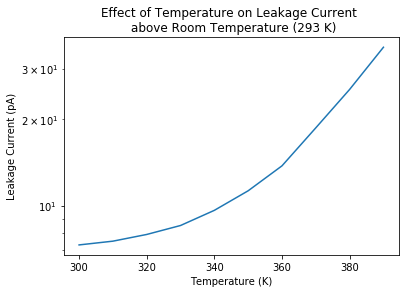

In [6]:
plt.plot(tempValues, [i * 10 ** 12 for i in resultValues])
plt.title("Effect of Temperature on Leakage Current \n above Room Temperature (293 K)")
plt.xlabel("Temperature (K)")
plt.ylabel("Leakage Current (pA)")
plt.yscale("log")
plt.show()

In [ ]:
temp(400)

In [103]:
numTSteps = 2000 # Number of time steps
N = 100 # Number of positions / electric field sheets

initialCC = 2000 # Inital Number of charge carriers for each holes, Na, Nd, and electrons
dt = 5.88 * 10 ** (-14) # Time step
dx = 2.0 * 10 ** (-8) # Position step
A = 1.0 * 10 ** (-11) # Area of PN-junction interface
N_a = initialCC
N_d = initialCC

holes_init = initialCC
elecs_init = initialCC

T = 400.0

min_carriers = 2 * (T / 300) ** (1.5) # minority carrier concentration

mobility_p = 0.04 * (T / 300) ** (-0.5)# mu value for hole
mobility_n = 0.13 * (T / 300) ** (-0.5)# mu value for electron

eps_s = 12 * 8.85 * 10 ** (-12)
eC = 1.6 * 10 ** (-19)

k = 1.38 * 10 ** (-23)



E_0 = eC / (eps_s * A)
thermal_voltage = k * T / eC

c1_p = mobility_p * E_0 * dt / (2 * dx)
c2_p = (thermal_voltage * mobility_p) * dt / (dx ** 2) 

c1_n = mobility_n * E_0 * dt / (2 * dx)
c2_n = (thermal_voltage * mobility_n) * dt / (dx ** 2)

print(c1_p * 1500 + c2_p)

0.187189776404


In [99]:
thermal_voltage = k * 400 / eC

In [100]:
print(thermal_voltage)

0.0345


In [123]:
T = 400
E_g0 = 1.17
E_g = E_g0 - 4.73 * 10 ** (-4) * T ** 2 / (T + 636)
print(E_g)

1.09694980695


In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy import random
import time


def temp(T):
    numTSteps = 2000 # Number of time steps
    N = 100 # Number of positions / electric field sheets

    initialCC = 2000 # Inital Number of charge carriers for each holes, Na, Nd, and electrons
    dt = 5.88 * 10 ** (-14) # Time step
    dx = 2.0 * 10 ** (-8) # Position step
    A = 1.0 * 10 ** (-11) # Area of PN-junction interface
    N_a = initialCC
    N_d = initialCC

    holes_init = initialCC
    elecs_init = initialCC


    eps_s = 12 * 8.85 * 10 ** (-12)
    eC = 1.6 * 10 ** (-19)

    k = 1.38 * 10 ** (-23)
    #T = 100


    E_0 = eC / (eps_s * A)
    thermal_voltage = k * T / eC
    E_g0 = 1.17 
    E_g = E_g0 - 4.73 * 10 ** (-4) * T ** 2 / (T + 636)
    min_carriers = 2 * (T / 300) ** 1.5 * math.exp(E_g * eC / (2.0 * k) * (1 / 300.0 - 1.0 / T)) # minority carrier concentration

    mobility_p = 0.04 * (T / 300) ** (-1.5)# mu value for hole
    mobility_n = 0.13 * (T / 300) ** (-1.5)# mu value for electron

    c1_p = mobility_p * E_0 * dt / (2 * dx)
    c2_p = (thermal_voltage * mobility_p) * dt / (dx ** 2) 

    c1_n = mobility_n * E_0 * dt / (2 * dx)
    c2_n = (thermal_voltage * mobility_n) * dt / (dx ** 2)

    Na = np.concatenate(((-1) * np.ones(N / 2) * N_a, np.zeros(N / 2)))
    Nd = np.concatenate((np.zeros(N / 2), np.ones(N / 2) * N_d))

    holes = np.concatenate((np.ones(N / 2) * holes_init, np.ones(N / 2) * min_carriers))
    elecs = np.concatenate((np.ones(N / 2) * min_carriers, np.ones(N / 2) * elecs_init))

    E = np.zeros(N)
    r_holes = np.zeros(N)
    r_elecs = np.zeros(N)
    l_holes = np.zeros(N)
    l_elecs = np.zeros(N)

    holes_tot = np.zeros(N)
    elecs_tot = np.zeros(N)

    E_tot = np.zeros(N)

    loop = 200

    # 2. Begin Simulation 

    for n in range(numTSteps): # Over Time
        temporaryH = np.zeros(N)
        temporaryE = np.zeros(N)

        for i in range(N): # Over Position
            #Determine Electric Field at Position i (External Voltage will be accounted for by adding another term)
            if i == 0:
                E[i] = (-1) * np.sum(holes[1:N] - elecs[1:N] + Na[1:N] + Nd[1:N]) / 2
            elif i == (N - 1): 
                E[i] = np.sum(holes[0:N-1] - elecs[0:N-1] + Na[0:N-1] + Nd[0:N-1]) / 2
            else:
                pos = range(0, i)
                neg = range(i + 1, N)

                pos_field = np.sum(holes[pos] - elecs[pos] + Na[pos] + Nd[pos])
                neg_field = np.sum(holes[neg] - elecs[neg] + Na[neg] + Nd[neg])

                E[i] = (pos_field - neg_field) / 2; 

            # Calculate probabilities of carrier motion 
            r_holes[i] = E[i] * c1_p + c2_p
            l_holes[i] = (-1) * E[i] * c1_p + c2_p
            r_elecs[i] = (-1) * E[i] * c1_n + c2_n
            l_elecs[i] = E[i] * c1_n + c2_n

            # Move the holes 
            numH = holes[i]
            numRight = 0
            numLeft = 0
            numStay = 0



            if r_holes[i] < 0:
                numRight = 0 
            elif r_holes[i] > 1: 
                numRight = numH
            else:
                numRight = int(r_holes[i] * numH)

            if l_holes[i] < 0:
                numLeft = 0 
            elif l_holes[i] > 1: 
                numLeft = numH
            else:
                numLeft = int(l_holes[i] * numH)

            numStay = numH - numRight - numLeft


            if i == 0:
                temporaryH[1] += numRight
                temporaryH[0] += numStay + numLeft

            elif i == (N - 1):
                temporaryH[N-1] += numStay + numRight
                temporaryH[N-2] += numLeft

            else:
                temporaryH[i] += numStay
                temporaryH[i - 1] += numLeft
                temporaryH[i + 1] += numRight

            # Move the electrons
            numE = elecs[i]
            numRight = 0
            numLeft = 0
            numStay = 0

            if r_elecs[i] < 0:
                numRight = 0 
            elif r_elecs[i] > 1: 
                numRight = numE
            else:
                numRight = int(r_elecs[i] * numE)

            if l_elecs[i] < 0:
                numLeft = 0 
            elif l_elecs[i] > 1: 
                numLeft = numE
            else:
                numLeft = int(l_elecs[i] * numE)


            numStay = numE - numRight - numLeft
            if i == 0:
                temporaryE[1] += numRight
                temporaryE[0] += numStay + numLeft

            elif i == (N - 1):
                temporaryE[N-1] += numStay + numRight
                temporaryE[N-2] += numLeft

            else:
                temporaryE[i] += numStay
                temporaryE[i - 1] += numLeft
                temporaryE[i + 1] += numRight

        # Update carrier distribution
        holes = temporaryH
        elecs = temporaryE

#         EHP Generation by EM Stimulation
        depletion_right = 55
        depletion_left = 45


        EHP_gen_num = int(0.000002222 * math.exp(0.046 * T) - 2.222)
        for i in range(EHP_gen_num):
            x = random.randint(0, N)
            holes[x] += 1
            elecs[x] += 1
        

        if n > (numTSteps - loop): # Averaging distribution over time
            holes_tot += holes
            elecs_tot += elecs
            E_tot += E

    holes_tot = holes_tot / loop
    elecs_tot = elecs_tot / loop
    E_tot = E_tot / loop
    tot = holes_tot - elecs_tot + Nd + Na

    sum = 0
    voltArray = []

    for i in range(N):
        sum += E_tot[i] * dx * E_0
        voltArray.append((-1) * sum)

    voltage = (voltArray[N-1] - voltArray[0])
    
    dif = math.sqrt((2 * eps_s * voltage) / eC * (5 * 10 ** (-23))) / dx

    Q_n = 0
    depletion_left = int(49 - dif)
    for i in range(depletion_left):
        Q_n += elecs[i]

    Q_p = 0 
    depletion_right = int(49 + dif)
    for i in range(depletion_right, N): 
        Q_p += holes[i]

    tau_p = 10 ** (-4) # Will adjust value to experimentally determined values
    tau_n = 10 ** (-4)

    I_tot = (Q_p / tau_p + Q_n / tau_n) * eC

    
    return(I_tot)

tempValues = np.arange(300.0, 400.0, 10)
resultValues = []

for tempa in tempValues:
    result = temp(tempa)
    resultValues.append(result)

plt.plot(tempValues, [i * 10 ** 12 for i in resultValues])
plt.title("Effect of Temperature on Leakage Current \n above Room Temperature (293 K)")
plt.xlabel("Temperature (K)")
plt.ylabel("Leakage Current (pA)")
plt.yscale("log")
plt.show()

45
300.0
7.353600000000001e-12
45
310.0
1.0160303700861214e-11
45
320.0
1.6089406906776334e-11
45
330.0
2.5059128956121468e-11
45
340.0
4.0264299737041047e-11
46
350.0
6.666129638864438e-11
46
360.0
1.0825402123858435e-10
46
370.0
1.730338638310563e-10
46
380.0
2.7701442844259095e-10
47
390.0
4.527798295193899e-10


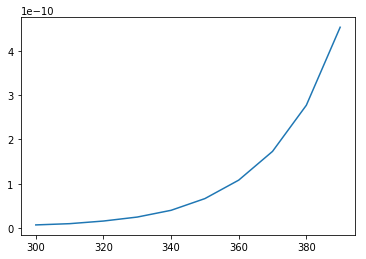

In [95]:
tempValues = np.arange(300.0, 400.0, 10)
resultValues = []

for tempa in tempValues:
    result = temp(tempa)
    resultValues.append(result)
    
plt.plot(tempValues, resultValues)

In [96]:
2 * (300 / 300) ** 1.5 * math.exp(E_g * eC / (2.0 * k) * (1 / 300.0 - 1.0 / T))

NameError: name 'E_g' is not defined

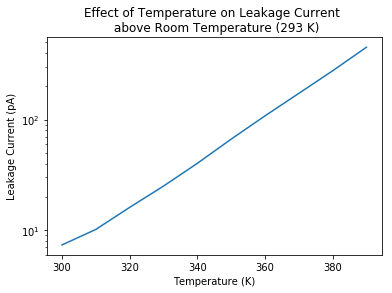

In [100]:
plt.plot(tempValues, [i * 10 ** 12 for i in resultValues])
plt.title("Effect of Temperature on Leakage Current \n above Room Temperature (293 K)")
plt.xlabel("Temperature (K)")
plt.ylabel("Leakage Current (pA)")
plt.yscale("log")
plt.show()

In [98]:
x = y= 5

In [99]:
y

5